In [ ]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-04-24
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io

from Function.ReceptiveField import *
from Function.SNNModule import *
from Function.plot_SNN import *
from Function.SNN import *
from Function.Stimulation_GPU import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the device to 'cpu'
device = 'cpu'

print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

In [ ]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16

# Set pixel dimensions (number of pixels in height and width)
pixel_h, pixel_w = 64, 48

# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [ ]:
num_stim = 1000
stimulation_horizontal_below = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
stimulation_horizontal_below_lowpressure = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
stimulation_horizontal_above = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
max_F = 5

F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])
for i, F_i in enumerate(F_array):
    horizontal_below = elongated_stim_v2(F=F_i, pixel_h=pixel_h,
                              pixel_w=pixel_w, position='below', orientation='horizontal')
    horizontal_below_lowpressure = elongated_stim_v2(F=F_i/5, pixel_h=pixel_h,
                              pixel_w=pixel_w, position='below', orientation='horizontal')
    horizontal_above = elongated_stim_v2(F=F_i, pixel_h=pixel_h,
                              pixel_w=pixel_w, position='above', orientation='horizontal')
    
    stimulation_horizontal_below[:, :, i] = horizontal_below
    stimulation_horizontal_below_lowpressure[:, :, i] = horizontal_below_lowpressure
    stimulation_horizontal_above[:, :, i] = horizontal_above
    
    if i in [100, 500, 900]:
        
        plt.imshow(stimulation_horizontal_below[:, :, i].cpu(),
                      cmap='gray', vmin=0, vmax=max_F+1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.imshow(stimulation_horizontal_above[:, :, i].cpu(),
                      cmap='gray', vmin=0, vmax=max_F)
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [ ]:
recording_stimulation(stimulation_horizontal_below, max_F = max_F,
                      filename='stimulation_horizontal_below.gif')
recording_stimulation(stimulation_horizontal_below_lowpressure, max_F = max_F,
                      filename='stimulation_horizontal_below_lowpressure.gif')
recording_stimulation(stimulation_horizontal_above,max_F = max_F , filename = 'stimulation_horizontal_above.gif')


In [ ]:
#1st layer
############################################################################################################################################################
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_step_height, SA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=9, kernel_h=11, step_size=5, device=device)
RA_RF, [RA_step_height, RA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=11, kernel_h=14, step_size=4, device=device)

# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',SA_step_height, 'with width =', SA_step_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',RA_step_height, 'with width =', RA_step_width)
############################################################################################################################################################

#2nd layer
############################################################################################################################################################
# Define optimized receptive fields and synaptic delays
CN_PN_RF = [torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]],device=device)*4]
CN_IN_RF = [torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],device=device)*0.5]
CN_SD = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

CN_INtoPN_RF = []

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, [SA_CN_PN_step_height, SA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_IN_RF, [SA_CN_IN_step_height, SA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_SD, [SA_CN_SD_step_height, SA_CN_SD_step_width]  = generate_weight(CN_SD, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
RA_CN_PN_RF, [RA_CN_PN_step_height, RA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_IN_RF, [RA_CN_IN_step_height, RA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_SD, [RA_CN_SD_step_height, RA_CN_SD_step_width] = generate_weight(CN_SD, pixel_h=RA_step_height, pixel_w=RA_step_width, step_size=1, device=device)

SA_INtoPN_RF, SA_INtoPN_DN = create_weight_matrix(len(SA_CN_IN_RF), len(SA_CN_PN_RF), connection_probability=0.2, device=device)
RA_INtoPN_RF, RA_INtoPN_DN = create_weight_matrix(len(RA_CN_IN_RF), len(RA_CN_PN_RF), connection_probability=0.2, device=device)

print("SA_CN_PN_RF shape: ", SA_CN_PN_RF.shape,"SA_CN_PN_step_height:", SA_CN_PN_step_height,"SA_CN_PN_step_width:", SA_CN_PN_step_width)
print("SA_CN_IN_RF shape: ", SA_CN_IN_RF.shape,"SA_CN_IN_step_height:", SA_CN_IN_step_height,"SA_CN_IN_step_width:", SA_CN_IN_step_width)
print("RA_CN_PN_RF shape: ", RA_CN_PN_RF.shape,"RA_CN_PN_step_height:", RA_CN_PN_step_height,"RA_CN_PN_step_width:", RA_CN_PN_step_width)
print("RA_CN_IN_RF shape: ", RA_CN_IN_RF.shape,"RA_CN_IN_step_height:", RA_CN_IN_step_height,"RA_CN_IN_step_width:", RA_CN_IN_step_width)
print("SA_INtoPN_RF shape: ", SA_INtoPN_RF.shape)
print("RA_INtoPN_RF shape: ", RA_INtoPN_RF.shape)
############################################################################################################################################################

#3rd layer
############################################################################################################################################################
# 3rd integration layer
# Define optimized receptive fields and synaptic delays
CN_PN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1 ,1]], device=device)]
CN_IN_RF_set = [torch.tensor([[0, 0, 0], [1, 1 ,1], [0, 0 ,0]], device=device)]
CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]
rf_sizes=[(7, 4)]
# CN_PN_RF_set = [torch.tensor([[0, 0, 0], [1, 1, 1], [0, 0, 0]], device=device),torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]], device=device)]
# CN_IN_RF_set = [torch.tensor([[1, 1, 1], [0, 0, 0], [1, 1, 1]], device=device),torch.tensor([[1, 0, 1], [1, 0, 1], [1, 0, 1]], device=device)]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device), torch.tensor(
#     [[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

# CN_PN_RF_set = [torch.tensor([[1, 1, 1], [0, 0, 0], [0, 0, 0]], device=device),torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]], device=device)]
# CN_IN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1, 1]], device=device),torch.tensor([[0, 0, 1], [0, 0, 1], [0, 0, 1]], device=device)]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

# CN_PN_RF_set = [torch.tensor([[1, 2, 1], [0, 0, 0], [1, 2, 1]], device=device), 
#                 torch.tensor([[1, 0, 0], [2, 0, 0], [1, 0, 0]], device=device),
#                 torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
#                 ]
# CN_IN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 2, 1]], device=device), 
#                 torch.tensor([[0, 0, 1], [0, 0, 2], [0, 0, 1]], device=device),
#                 torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
#                 ]
# CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device), 
#              torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
#              torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
#              ]

# CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_PN_SA_RF, [CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_IN_SA_RF, [CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_SA_SD, [CN_SA_SD_step_height, CN_SA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)

CN_PN_RA_RF, [CN_PN_RA_RF_step_height, CN_PN_RA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_IN_RA_RF, [CN_IN_RA_RF_step_height, CN_IN_RA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_RA_SD, [CN_RA_SD_step_height, CN_RA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)

CN_INtoPN_RF, CN_INtoPN_DN = create_weight_matrix(len(CN_IN_SA_RF), len(CN_PN_SA_RF), connection_probability=0.2, device=device)

print("CN_PN_SA_RF shape: ", CN_PN_SA_RF.shape, "CN_PN_SA_RF_step_height:", CN_PN_SA_RF_step_height, "CN_PN_SA_RF_step_width:", CN_PN_SA_RF_step_width)
print("CN_IN_SA_RF shape: ", CN_IN_SA_RF.shape, "CN_IN_SA_RF_step_height:", CN_IN_SA_RF_step_height, "CN_IN_SA_RF_step_width:", CN_IN_SA_RF_step_width)
print("CN_PN_RA_RF shape: ", CN_PN_RA_RF.shape, "CN_PN_RA_RF_step_height:", CN_PN_RA_RF_step_height, "CN_PN_RA_RF_step_width:", CN_PN_RA_RF_step_width)
print("CN_IN_RA_RF shape: ", CN_IN_RA_RF.shape, "CN_IN_RA_RF_step_height:", CN_IN_RA_RF_step_height, "CN_IN_RA_RF_step_width:", CN_IN_RA_RF_step_width)
print("CN_INtoPN_RF shape: ", CN_INtoPN_RF.shape)
############################################################################################################################################################

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(CN_PN_SA_RF[0].reshape(9, 6) * 1 -
           CN_IN_SA_RF[0].reshape(9, 6), cmap='coolwarm', vmin=-3, vmax=3)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(CN_PN_RA_RF[0].reshape(11, 8) * 1 -
           CN_IN_RA_RF[0].reshape(11, 8), cmap='coolwarm',vmin = -3, vmax = 3)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

print(torch.nonzero(CN_PN_SA_RF[0]))

plt.figure()
plt.imshow(torch.sum(SA_CN_PN_RF[torch.nonzero(CN_PN_SA_RF[0])], axis=0).reshape(11, 8) * 1
           - torch.sum(SA_CN_IN_RF[torch.nonzero(CN_IN_SA_RF[0])], axis = 0).reshape(11, 8) * 1, cmap='coolwarm',vmin = -3, vmax = 3)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure()
plt.imshow(torch.sum(RA_CN_PN_RF[torch.nonzero(CN_PN_RA_RF[0])],axis = 0).reshape(13,10)*1
 - torch.sum(RA_CN_IN_RF[torch.nonzero(CN_IN_RA_RF[0])],axis = 0).reshape(13,10)*1
 , cmap='coolwarm',vmin = -3, vmax = 3)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

weight = torch.sum(SA_CN_PN_RF[torch.nonzero(
    CN_PN_SA_RF[0])], axis=0) - torch.sum(SA_CN_IN_RF[torch.nonzero(CN_IN_SA_RF[0])], axis=0) * 1
sa_receptive_field = torch.matmul(weight, SA_RF)
plt.figure()
plt.imshow(sa_receptive_field.reshape(64, 48), cmap='coolwarm',vmin = -3, vmax = 3)
plt.xticks([])
plt.yticks([])
plt.show()

weight = torch.sum(RA_CN_PN_RF[torch.nonzero(CN_PN_RA_RF[0])], axis=0) * 1 - torch.sum(RA_CN_IN_RF[torch.nonzero(CN_IN_RA_RF[0])], axis=0) * 1
ra_receptive_field = torch.matmul(weight, RA_RF)
plt.figure()
plt.imshow(ra_receptive_field.reshape(64, 48),
           cmap='coolwarm',vmin = -4, vmax = 4)
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
noise_std_val = 4

# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.01, noise_std = noise_std_val, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -70, 2, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)


RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -70, 2, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
RA_synapses = [RA_synapse, RA_CN_IN_synapse,RA_CN_PN_synapse,  RA_CN_INtoPN_synapse]

# 3rd layer 
CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 2, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

CN_layers = [CN_IN_layer, CN_PN_layer]
CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]



In [ ]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_horizontal_below)
plt.rcParams['font.size'] = 20
fig_size = (20, 10)
line_lengths = 0.6
plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[1])
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[2])

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[1])
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[2])

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[0])
# plot_total_spike_2D(S.CN_spike_times[0][28:56], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[1])
# plot_total_spike_2D(S.CN_spike_times[1][28:56], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))

In [ ]:
plot_spike_times_gif(S.CN_spike_times[1], size=fig_size, colors='tab:orange', 
                     save_gif=True, file_name = 'spike_times_animation_horizontal_below.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
                        save_gif=True, file_name='heatmap_animation_horizontal_below.gif')

In [ ]:
plot_spike_times(torch.cat((S.SA_spike_times[0], S.RA_spike_times[0]), dim=0), size=fig_size, colors='tab:blue',save_fig = 1)


In [ ]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_horizontal_below_lowpressure)
plt.rcParams['font.size'] = 20
fig_size = (20, 10)
line_lengths = 0.6
plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[1])
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[2])

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[1])
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[2])

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[0])
# plot_total_spike_2D(S.CN_spike_times[0][28:56], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[1])
# plot_total_spike_2D(S.CN_spike_times[1][28:56], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))

In [ ]:
plot_spike_times_gif(S.CN_spike_times[1], size=fig_size, colors='tab:orange', 
                     save_gif=True, file_name = 'spike_times_animation_horizontal_below_lowpressure.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
                        save_gif=True, file_name='heatmap_animation_horizontal_below_lowpressure.gif')

In [ ]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_horizontal_above)

plot_spike_times(S.SA_spike_times[0], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[1], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[1])
plot_spike_times(S.SA_spike_times[2], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[2])

plot_spike_times(S.RA_spike_times[0], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[1], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[1])
plot_spike_times(S.RA_spike_times[2], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[2])

plot_spike_times(S.CN_spike_times[0], size=fig_size,
                 colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[0])
# plot_total_spike_2D(S.CN_spike_times[0][28:56], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1], size=fig_size,
                 colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[1])
# plot_total_spike_2D(S.CN_spike_times[1][28:56], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))



In [ ]:
plot_spike_times_gif(
    S.CN_spike_times[1], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_animation_horizontal_above.gif')

plot_total_spike_2D_gif(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
                        save_gif=True, file_name='heatmap_animation_horizontal_above.gif')

In [ ]:
stimulation_slip_dot = generate_slip_dot(F = 5)



In [ ]:
recording_stimulation(stimulation_slip_dot,max_F = 10 , filename = 'stimulation_slip_dot.gif')

In [ ]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses,
             RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_slip_dot)


plot_spike_times(S.SA_spike_times[0], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[1], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[1])
plot_spike_times(S.SA_spike_times[2], size=fig_size,
                 colors='tab:blue', line_lengths=line_lengths)
plot_firing_rates(S.SA_spike_times[2])

plot_spike_times(S.RA_spike_times[0], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[0])
plot_spike_times(S.RA_spike_times[1], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[1])
plot_spike_times(S.RA_spike_times[2], size=fig_size,
                 colors='tab:red', line_lengths=line_lengths)
plot_firing_rates(S.RA_spike_times[2])

plot_spike_times(S.CN_spike_times[0], size=fig_size,
                 colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[0])
# plot_total_spike_2D(S.CN_spike_times[0][28:56], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1], size=fig_size,
                 colors='tab:orange', line_lengths=line_lengths)
plot_firing_rates(S.CN_spike_times[1])
# plot_total_spike_2D(S.CN_spike_times[1][28:56], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))


In [ ]:
plot_spike_times_gif(
    S.CN_spike_times[1], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_slip_dot.gif')

plot_total_spike_2D_gif(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
                        save_gif=True, file_name='heatmap_animation_slip_dot.gif')

plot_spike_times_gif(
    S.SA_spike_times[2], size=fig_size, colors='tab:blue',
      save_gif=True, file_name = 'spike_times_slip_dot_SA.gif' , line_lengths=0.6)

plot_total_spike_2D_gif(S.SA_spike_times[2], size=(SA_CN_PN_step_height,SA_CN_PN_step_width), 
                        save_gif=True, file_name='heatmap_animation_slip_dot_SA.gif')

plot_spike_times_gif(
    S.RA_spike_times[2], size=fig_size, colors='tab:red',
      save_gif=True, file_name = 'spike_times_slip_dot_RA.gif', line_lengths=0.6)

plot_total_spike_2D_gif(S.RA_spike_times[2], size=(RA_CN_PN_step_height,RA_CN_PN_step_width), 
                        save_gif=True, file_name='heatmap_animation_slip_dot_RA.gif')

In [ ]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 8
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, w=1)
    stimulation_angle_0[:, :, i] = stim_dot
    if i  in [300, 500, 700]:
        plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 8
for i in range(num_stim):
    x0 = i * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, theta=np.pi/2, w=1)
    stimulation_angle_90[:, :, i] = stim_dot
    if i in [300, 500, 700]:
        plt.imshow(stimulation_angle_90[:, :, i].cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [ ]:
#1st layer
############################################################################################################################################################
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_step_height, SA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=9, kernel_h=11, step_size=5, device=device)
RA_RF, [RA_step_height, RA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=11, kernel_h=14, step_size=4, device=device)

# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',SA_step_height, 'with width =', SA_step_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',RA_step_height, 'with width =', RA_step_width)
############################################################################################################################################################

#2nd layer
############################################################################################################################################################
# Define optimized receptive fields and synaptic delays
CN_PN_RF = [torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], device=device)*4]
CN_IN_RF = [torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]], device=device)*0.5]
CN_SD = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

CN_INtoPN_RF = []

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, [SA_CN_PN_step_height, SA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_IN_RF, [SA_CN_IN_step_height, SA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_SD, [SA_CN_SD_step_height, SA_CN_SD_step_width]  = generate_weight(CN_SD, pixel_h=SA_step_height,pixel_w=SA_step_width, step_size=1, device=device)
RA_CN_PN_RF, [RA_CN_PN_step_height, RA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_IN_RF, [RA_CN_IN_step_height, RA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=RA_step_height,pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_SD, [RA_CN_SD_step_height, RA_CN_SD_step_width] = generate_weight(CN_SD, pixel_h=RA_step_height, pixel_w=RA_step_width, step_size=1, device=device)

SA_INtoPN_RF, SA_INtoPN_DN = create_weight_matrix(len(SA_CN_IN_RF), len(SA_CN_PN_RF), connection_probability=0.2, device=device)
RA_INtoPN_RF, RA_INtoPN_DN = create_weight_matrix(len(RA_CN_IN_RF), len(RA_CN_PN_RF), connection_probability=0.2, device=device)

print("SA_CN_PN_RF shape: ", SA_CN_PN_RF.shape,"SA_CN_PN_step_height:", SA_CN_PN_step_height,"SA_CN_PN_step_width:", SA_CN_PN_step_width)
print("SA_CN_IN_RF shape: ", SA_CN_IN_RF.shape,"SA_CN_IN_step_height:", SA_CN_IN_step_height,"SA_CN_IN_step_width:", SA_CN_IN_step_width)
print("RA_CN_PN_RF shape: ", RA_CN_PN_RF.shape,"RA_CN_PN_step_height:", RA_CN_PN_step_height,"RA_CN_PN_step_width:", RA_CN_PN_step_width)
print("RA_CN_IN_RF shape: ", RA_CN_IN_RF.shape,"RA_CN_IN_step_height:", RA_CN_IN_step_height,"RA_CN_IN_step_width:", RA_CN_IN_step_width)
print("SA_INtoPN_RF shape: ", SA_INtoPN_RF.shape)
print("RA_INtoPN_RF shape: ", RA_INtoPN_RF.shape)
############################################################################################################################################################

#3rd layer
############################################################################################################################################################
# 3rd integration layer
# Define optimized receptive fields and synaptic delays
# CN_PN_RF_set = [
#     torch.tensor([[0, 0, 0], [1, 2, 1], [0, 0, 0]], device=device),
#     torch.tensor([[0, 0, 0], [1, 2, 1], [0, 0, 0]], device=device),
# ]

# CN_IN_RF_set = [
#     torch.tensor([[1, 2, 1], [0, 0, 0], [0, 0, 0]], device=device),
#     torch.tensor([[1, 2, 1], [0, 0, 0], [0, 0, 0]], device=device),
# ]
# CN_SD_set = [
#     torch.tensor([[49, 49, 49], [25, 25, 25], [2, 2, 2]], device=device),
#     torch.tensor([[2, 2, 2], [25, 25, 25], [49, 49, 49]], device=device),
# ]
CN_PN_RF_set = [
    torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]], device=device),
    torch.tensor([[0, 0, 0], [1, 1, 1], [0, 0, 0]], device=device),
]

CN_IN_RF_set = [
    torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]], device=device),
    torch.tensor([[1, 1, 1], [0, 0, 0], [0, 0, 0]], device=device),
]

# CN_PN_RF_set = [
#     torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]], device=device),
#     torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]], device=device),
# ]

# CN_IN_RF_set = [
#     torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]], device=device),
#     torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]], device=device),
# ]
CN_SD_set = [
    torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
    torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
]
# CN_SD_set = [
#     torch.tensor([[1, 24, 29], [1, 24, 29], [1, 24, 29]], device=device),
#     torch.tensor([[29, 24, 1], [29, 24, 1], [29, 24, 1]], device=device),
# ]
rf_sizes = [(7, 4), (7, 4)]

# CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_PN_SA_RF, [CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_IN_SA_RF, [CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_SA_SD, [CN_SA_SD_step_height, CN_SA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)

CN_PN_RA_RF, [CN_PN_RA_RF_step_height, CN_PN_RA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_IN_RA_RF, [CN_IN_RA_RF_step_height, CN_IN_RA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_RA_SD, [CN_RA_SD_step_height, CN_RA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)

CN_INtoPN_RF, CN_INtoPN_DN = create_weight_matrix(len(CN_IN_SA_RF), len(CN_PN_SA_RF), connection_probability=0.2, device=device)

print("CN_PN_SA_RF shape: ", CN_PN_SA_RF.shape, "CN_PN_SA_RF_step_height:", CN_PN_SA_RF_step_height, "CN_PN_SA_RF_step_width:", CN_PN_SA_RF_step_width)
print("CN_IN_SA_RF shape: ", CN_IN_SA_RF.shape, "CN_IN_SA_RF_step_height:", CN_IN_SA_RF_step_height, "CN_IN_SA_RF_step_width:", CN_IN_SA_RF_step_width)
print("CN_PN_RA_RF shape: ", CN_PN_RA_RF.shape, "CN_PN_RA_RF_step_height:", CN_PN_RA_RF_step_height, "CN_PN_RA_RF_step_width:", CN_PN_RA_RF_step_width)
print("CN_IN_RA_RF shape: ", CN_IN_RA_RF.shape, "CN_IN_RA_RF_step_height:", CN_IN_RA_RF_step_height, "CN_IN_RA_RF_step_width:", CN_IN_RA_RF_step_width)
print("CN_INtoPN_RF shape: ", CN_INtoPN_RF.shape)
############################################################################################################################################################
noise_std_val = 5

# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -70, 2, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)


RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -70, 2, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
RA_synapses = [RA_synapse, RA_CN_IN_synapse,RA_CN_PN_synapse,  RA_CN_INtoPN_synapse]

# 3rd layer 
CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 2, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
CN_PN_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

CN_layers = [CN_IN_layer, CN_PN_layer]
CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]

In [ ]:

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_angle_0)

plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(SA_step_height,SA_step_width))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(SA_CN_PN_step_height,SA_CN_PN_step_width))
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(SA_CN_IN_step_height, SA_CN_IN_step_width))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[0], size=(RA_step_height,RA_step_width))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[1], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[2], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[0][0:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width], size=(CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[0][CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))


In [ ]:
stim = stimulation_angle_0
stim_name = 'stimulation_angle_0'

recording_stimulation(stim,max_F = 10 , filename = 'stimulation_'+stim_name+'.gif')

plot_spike_times_gif(
    S.CN_spike_times[1], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_animation_'+stim_name+'.gif')

# plot_total_spike_2D_gif(S.CN_spike_times[1], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
#                         save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')

In [ ]:

stim_name = 'stimulation_angle_0_SA'
plot_total_spike_2D_gif(S.SA_spike_times[2], size=(
    SA_CN_IN_step_height, SA_CN_IN_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')
stim_name = 'stimulation_angle_0_kernel1'
plot_spike_times_gif(
    S.CN_spike_times[1][0:CN_PN_SA_RF_step_height *
                        CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')
stim_name = 'stimulation_angle_0_kernel2'
plot_spike_times_gif(
    S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2]
    , size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')




In [ ]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_angle_90)

plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(SA_step_height,SA_step_width))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(SA_CN_PN_step_height,SA_CN_PN_step_width))
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(SA_CN_IN_step_height, SA_CN_IN_step_width))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[0], size=(RA_step_height,RA_step_width))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[1], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[2], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[0][0:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width], size=(CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[0][CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:
                 CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))


In [ ]:
stim = stimulation_angle_90
stim_name = 'stimulation_angle_90'

recording_stimulation(stim,max_F = 8 , filename = 'stimulation_'+stim_name+'.gif')

plot_spike_times_gif(
    S.CN_spike_times[1], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_animation_'+stim_name+'.gif')

stim_name = 'stimulation_angle_90_kernel1'
plot_spike_times_gif(
    S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), 
                        save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')
stim_name = 'stimulation_angle_90_kernel2'
plot_spike_times_gif(
    S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=fig_size, colors='tab:orange',
      save_gif=True, file_name = 'spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width),
                        save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')


In [ ]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0_notmoving = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 8
for i in range(num_stim):
    x0 = 500 * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = 500 * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, w=1)
    stimulation_angle_0_notmoving[:, :, i] = stim_dot
    if i in [300, 500, 700]:
        plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90_notmoving = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 8
for i in range(num_stim):
    x0 = 500 * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = 500 * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, theta=np.pi/2, w=1)
    stimulation_angle_90_notmoving[:, :, i] = stim_dot
    if i in [300, 500, 700]:
        plt.imshow(stimulation_angle_90[:, :, i].cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()


start feedforward
torch.Size([64, 48, 1000])


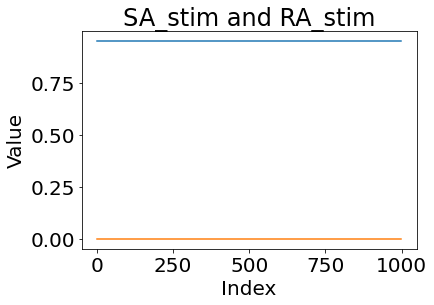

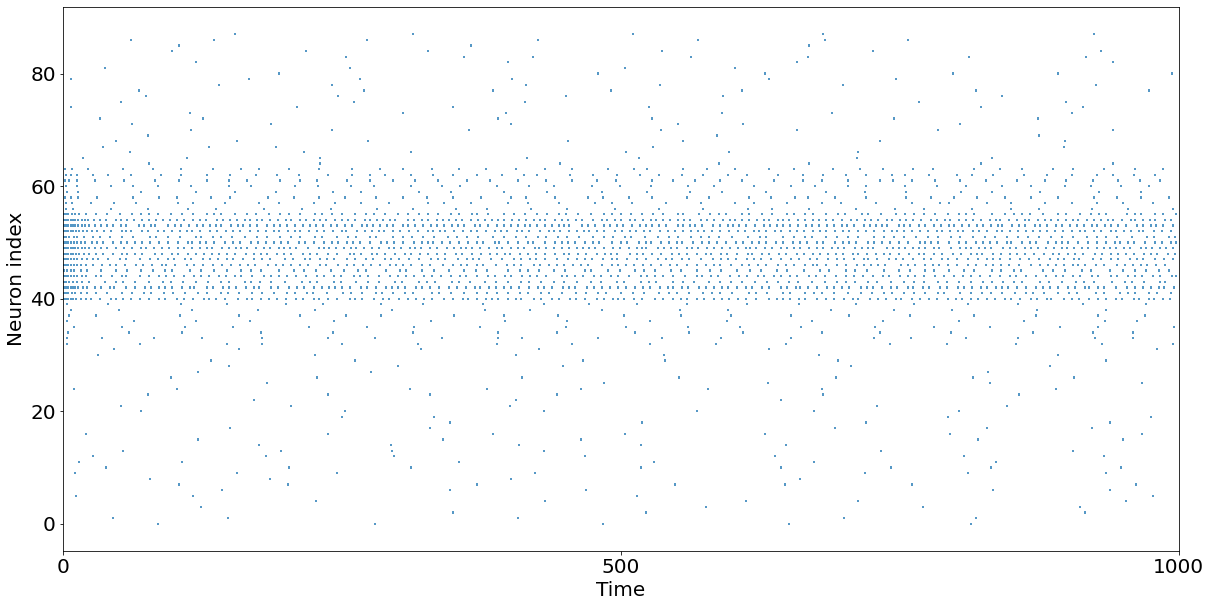

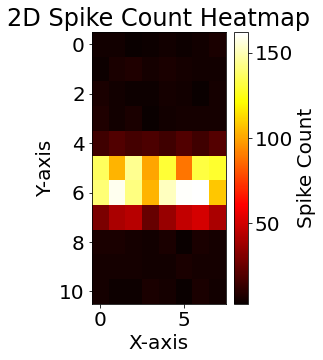

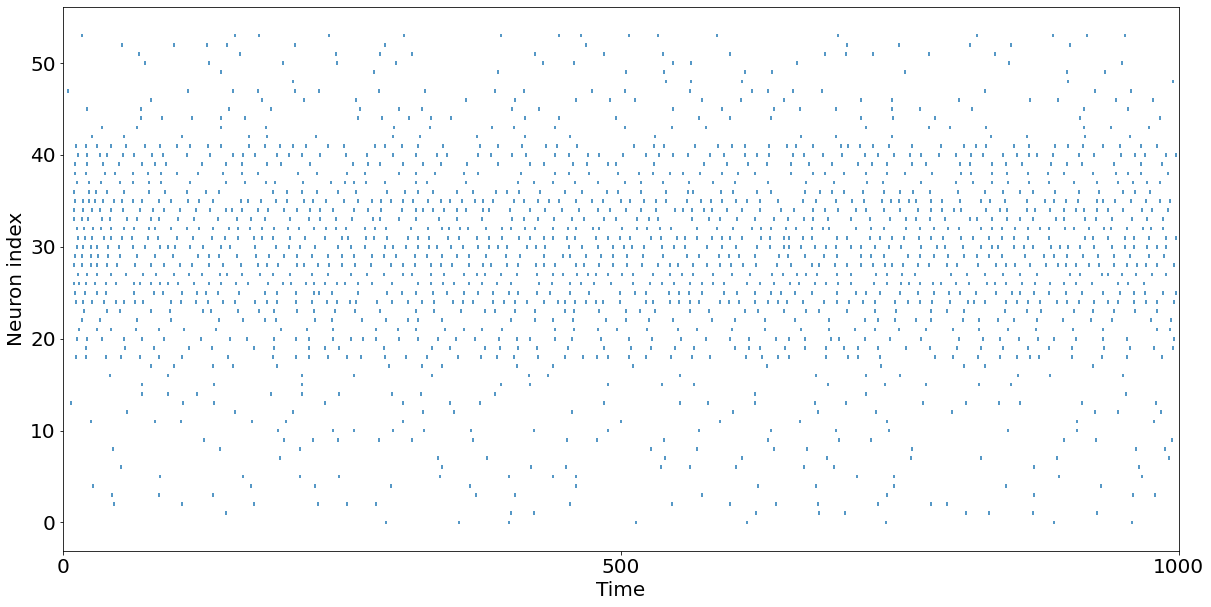

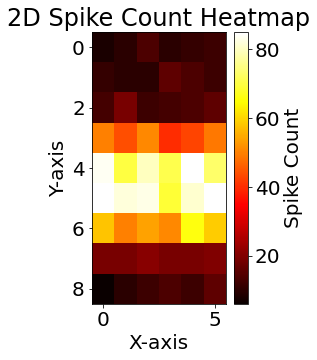

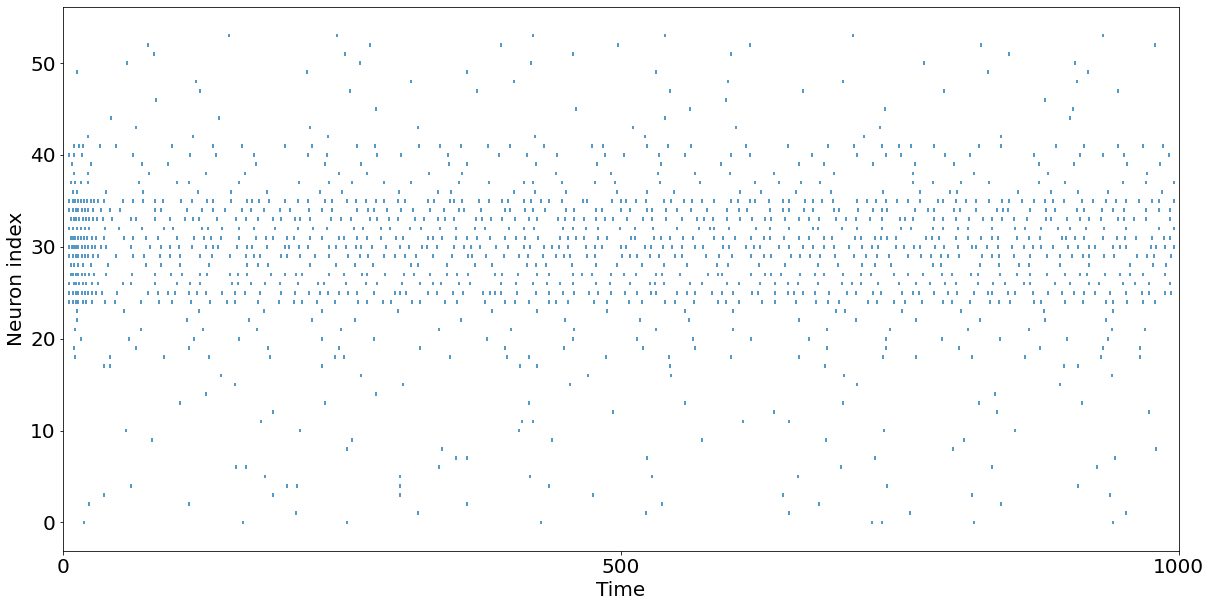

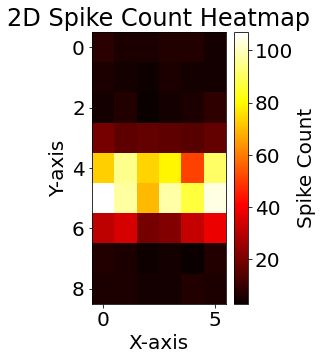

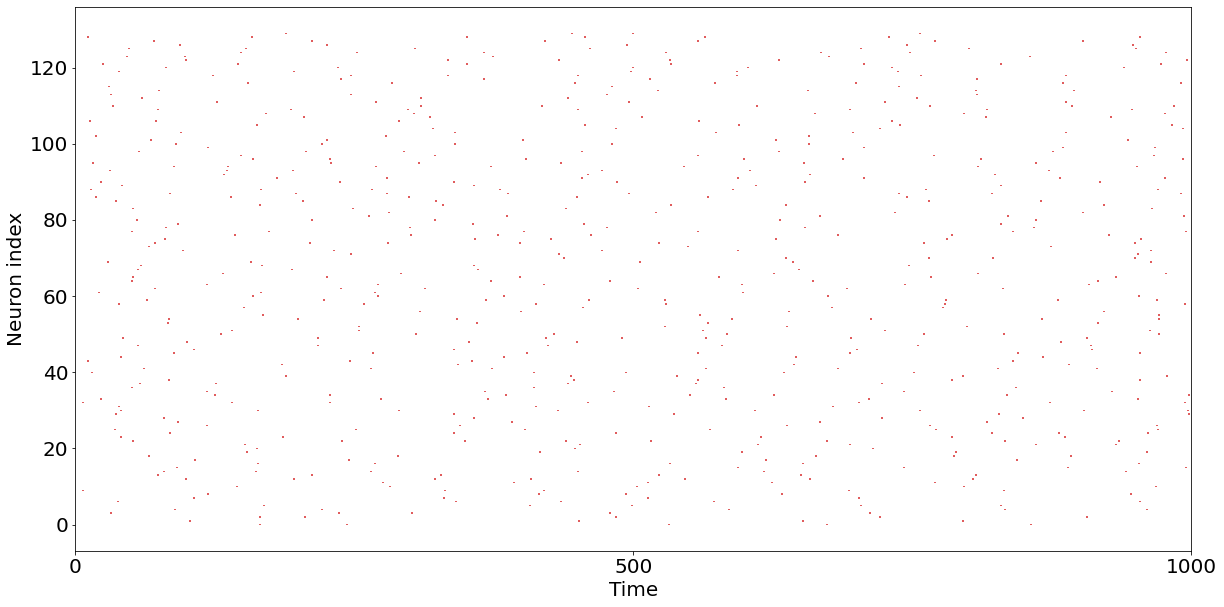

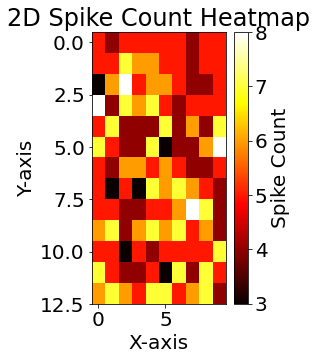

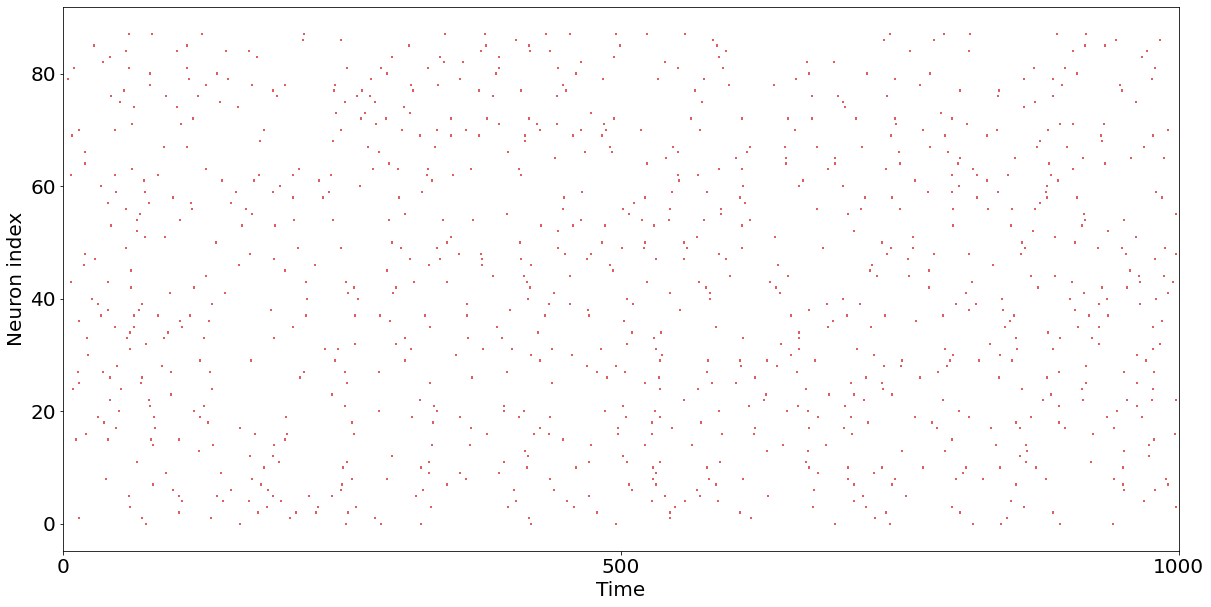

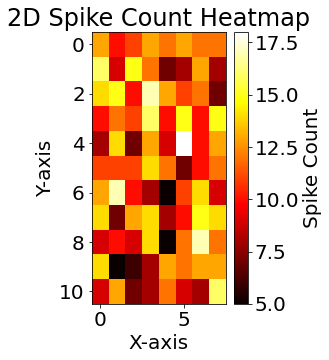

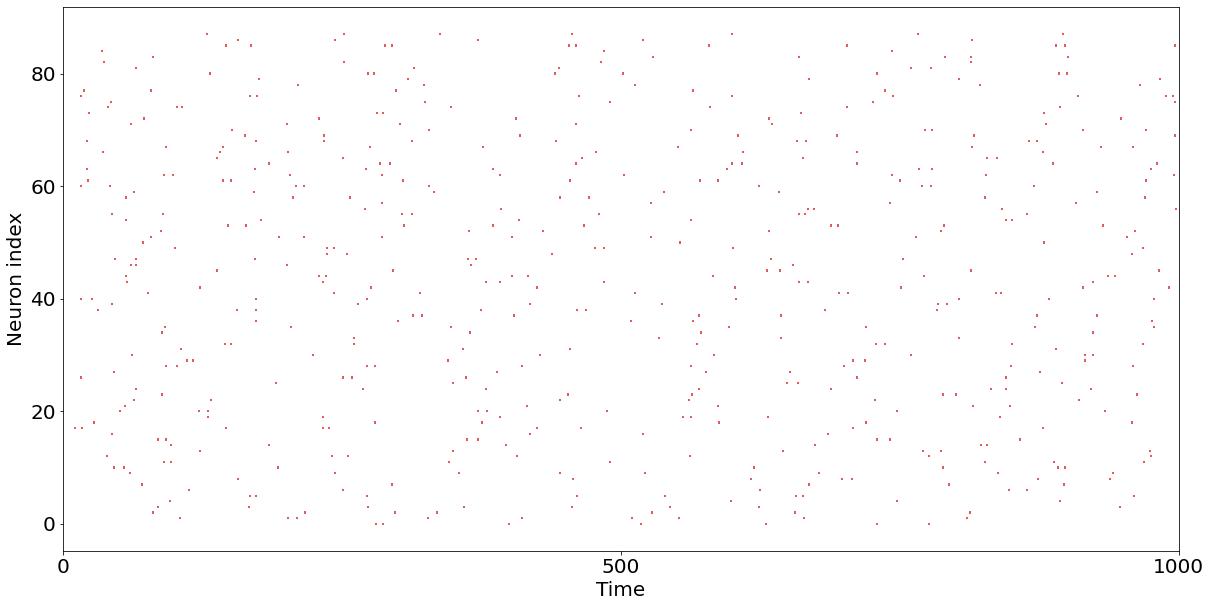

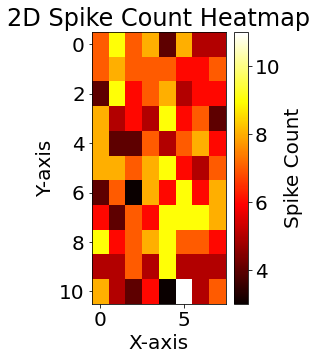

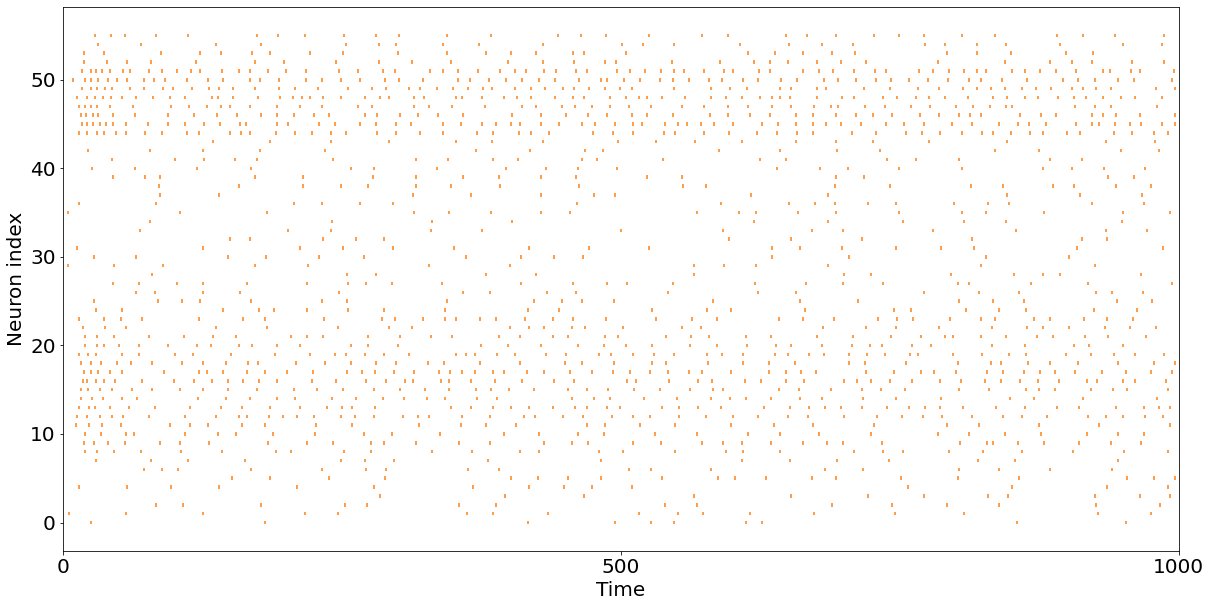

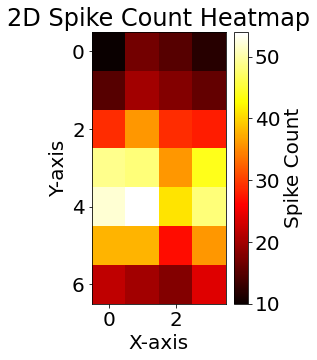

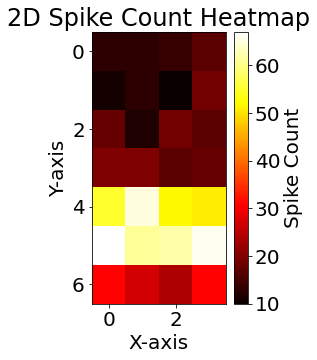

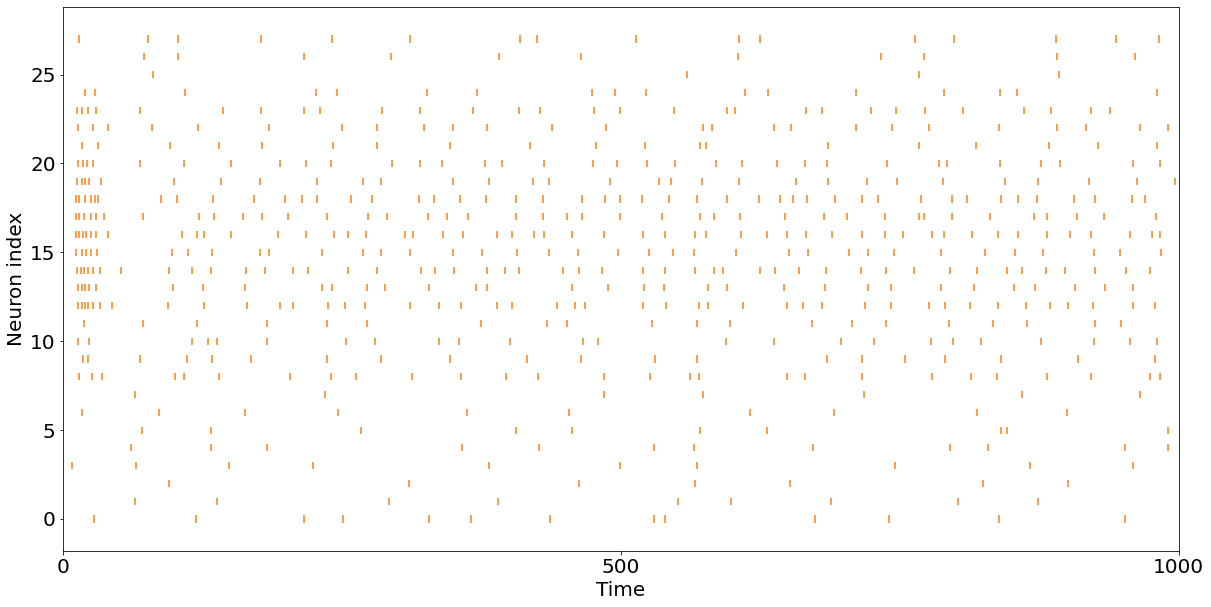

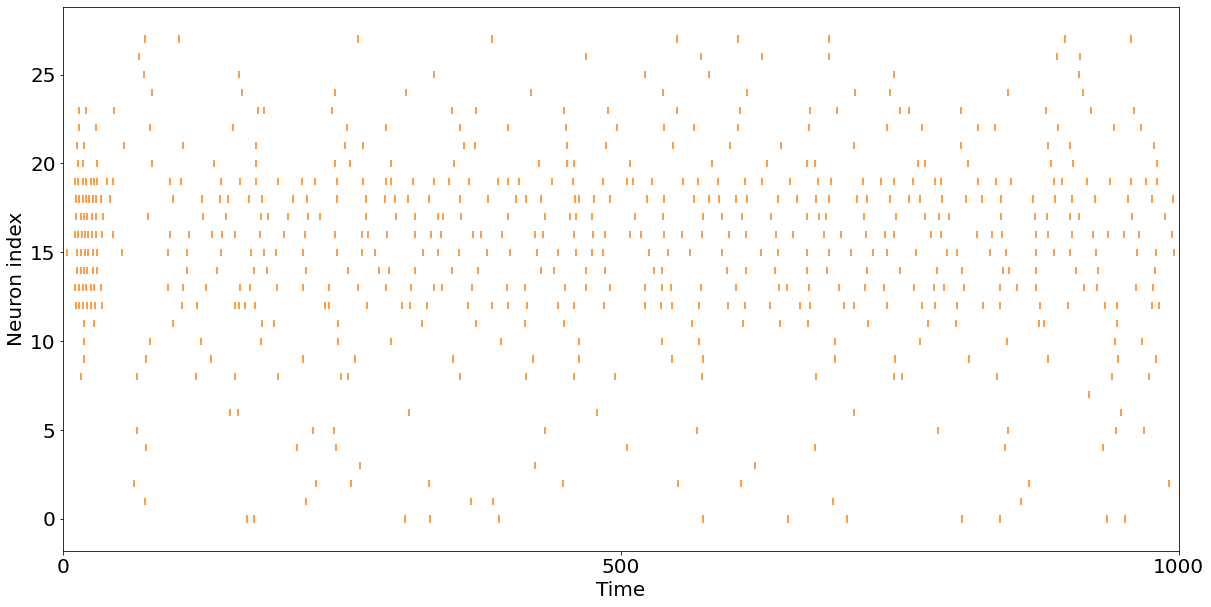

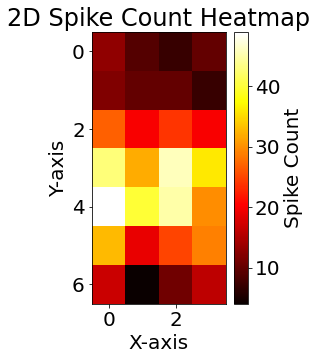

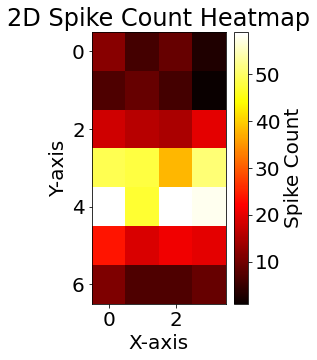

In [53]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_angle_0_notmoving)

plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(SA_step_height,SA_step_width))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(SA_CN_PN_step_height,SA_CN_PN_step_width))
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(SA_CN_IN_step_height, SA_CN_IN_step_width))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[0], size=(RA_step_height,RA_step_width))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[1], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[2], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[0][0:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width], size=(CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[0][CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:
                 CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))


In [54]:
stim_name = 'stimulation_angle_0_notmoving_kernel1'
plot_spike_times_gif(
    S.CN_spike_times[1][0:CN_PN_SA_RF_step_height *
                        CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')
stim_name = 'stimulation_angle_0_notmoving_kernel2'
plot_spike_times_gif(
    S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2]
    , size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')

start feedforward
torch.Size([64, 48, 1000])


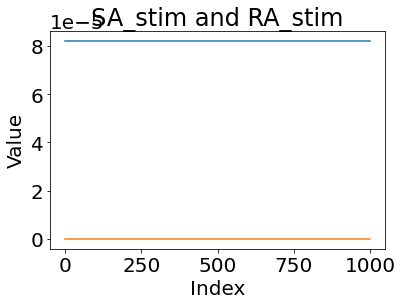

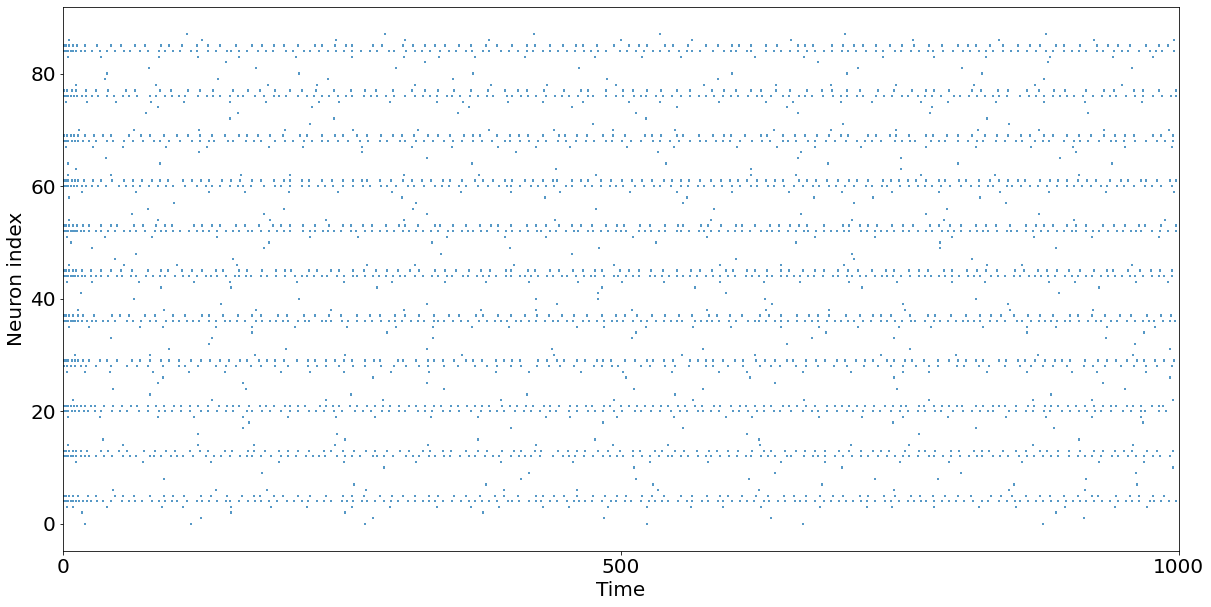

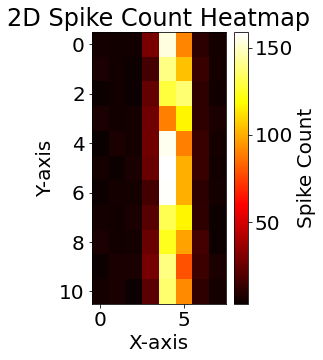

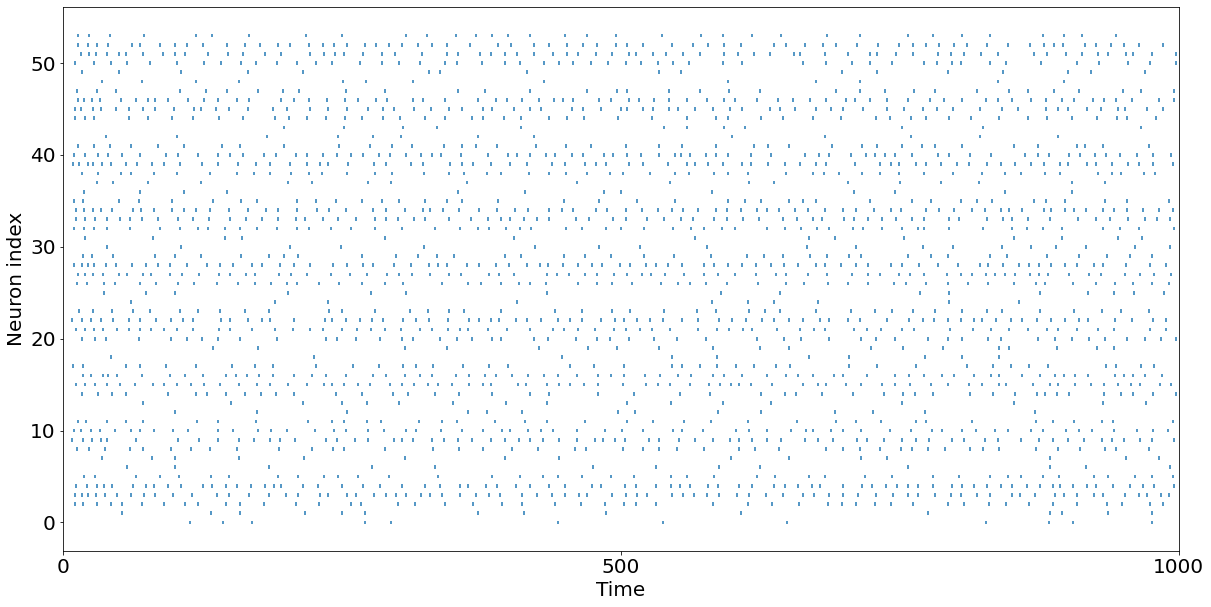

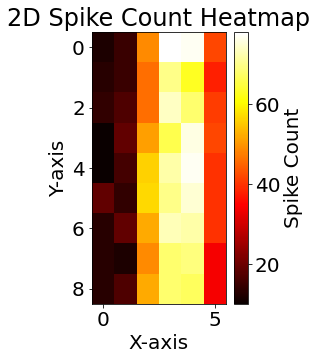

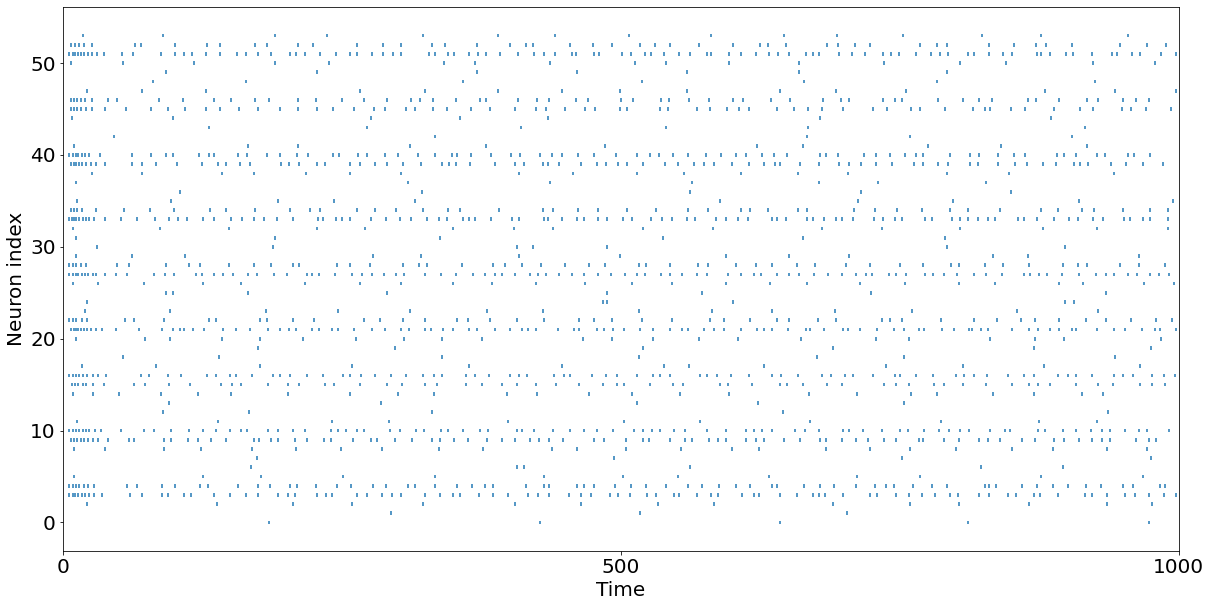

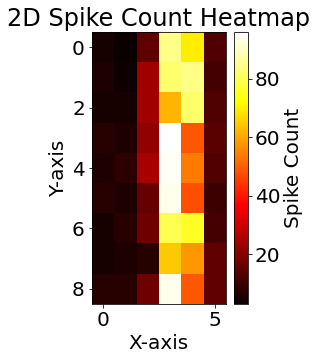

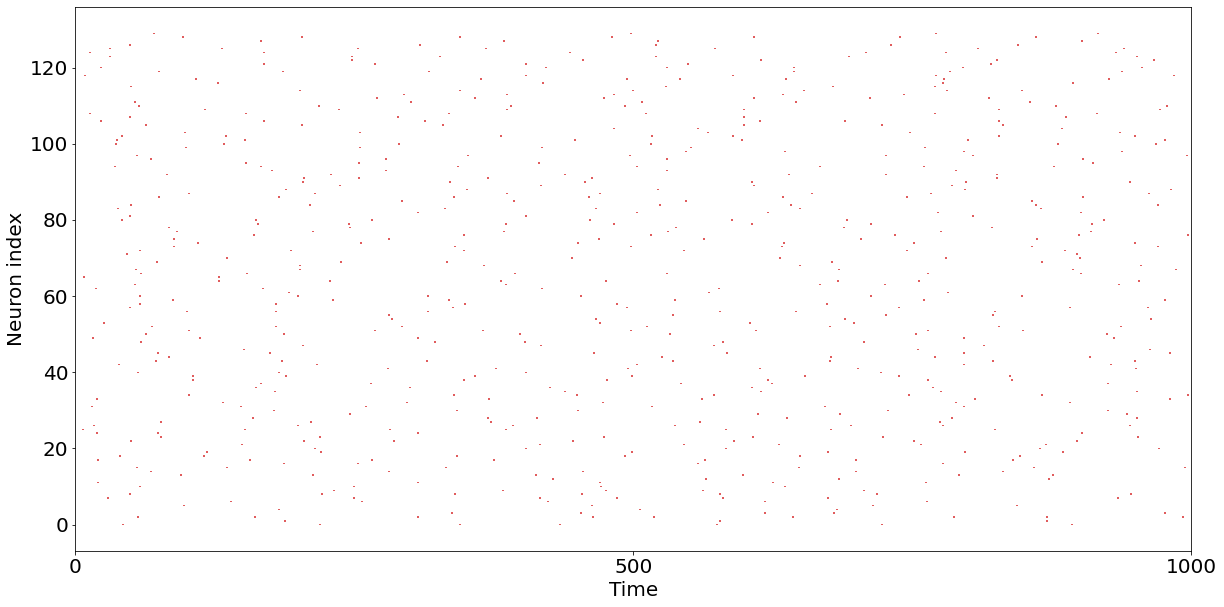

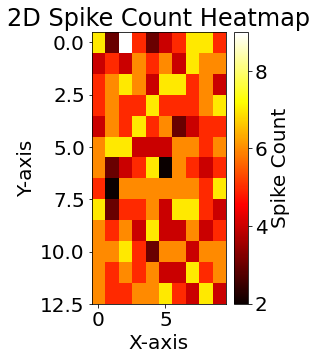

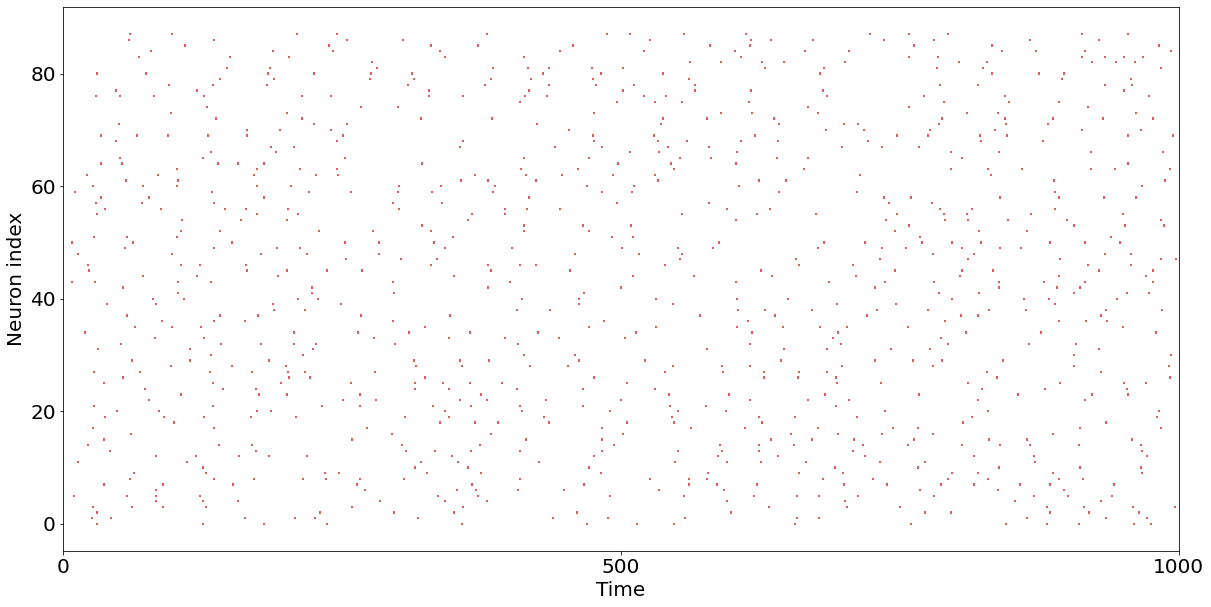

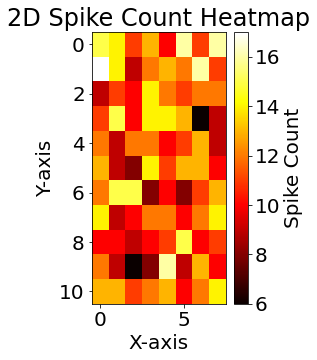

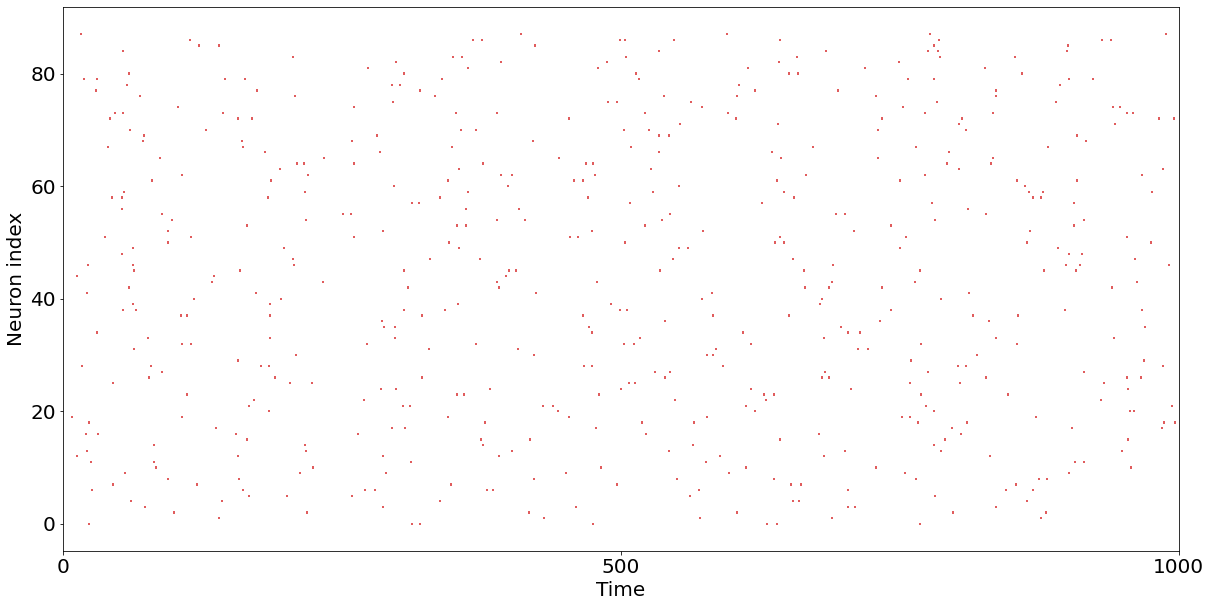

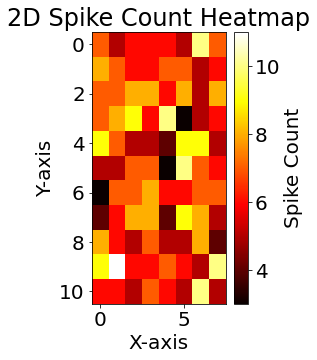

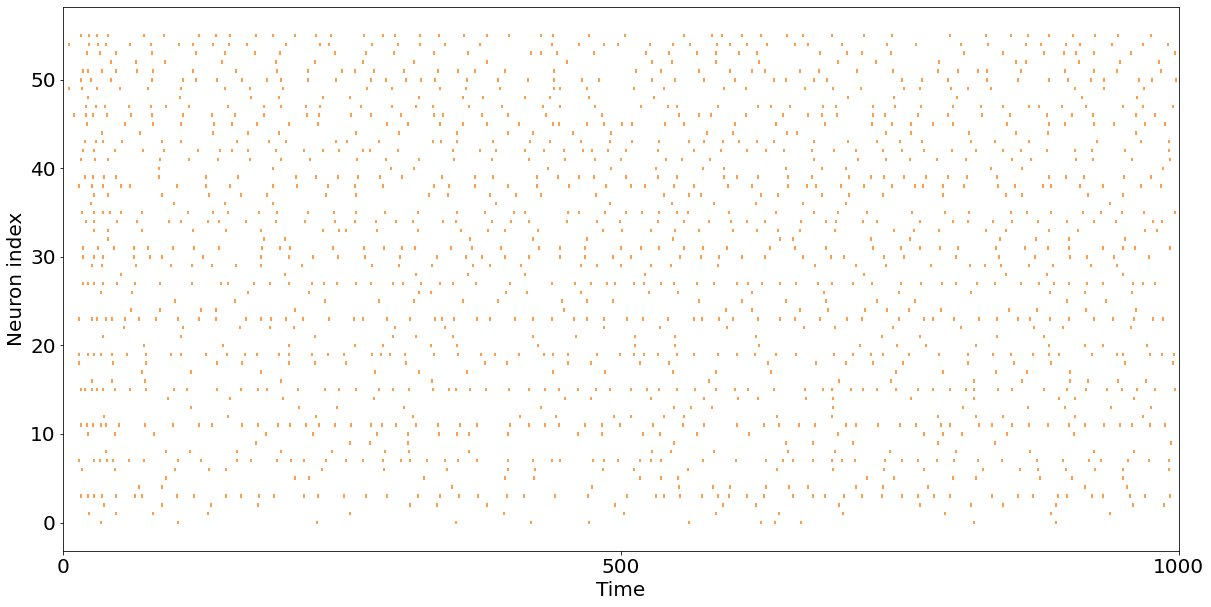

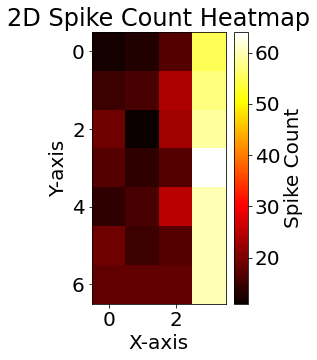

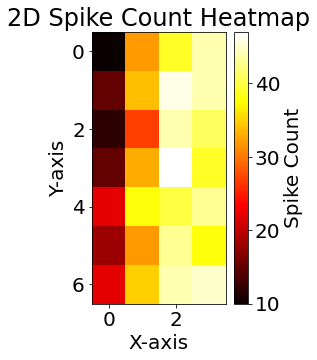

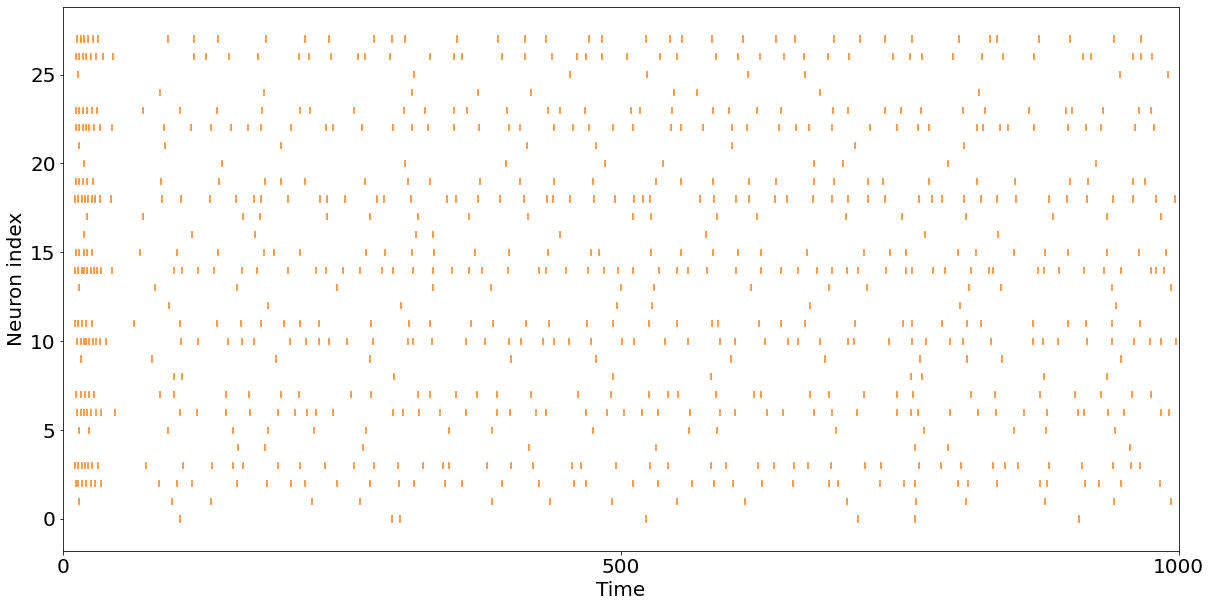

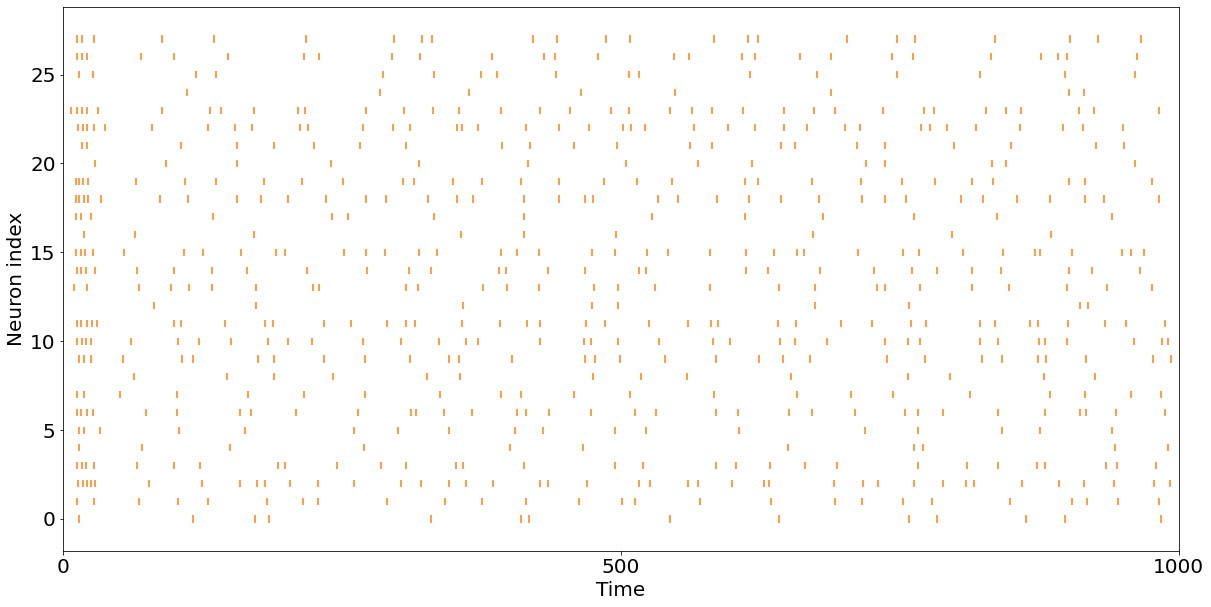

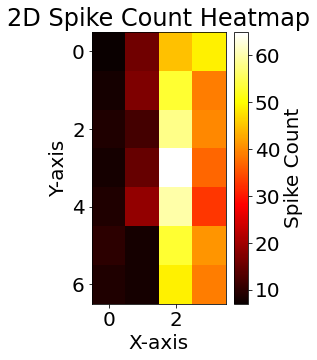

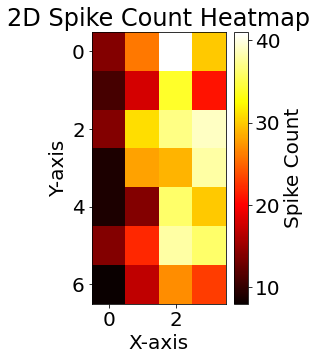

In [55]:
S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

S.feedforward(stimulation_angle_90_notmoving)

plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(SA_step_height,SA_step_width))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(SA_CN_PN_step_height,SA_CN_PN_step_width))
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(SA_CN_IN_step_height, SA_CN_IN_step_width))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[0], size=(RA_step_height,RA_step_width))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[1], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:red')
plot_total_spike_2D(S.RA_spike_times[2], size=(RA_CN_PN_step_height,RA_CN_PN_step_width))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[0][0:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width], size=(CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[0][CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width:CN_IN_SA_RF_step_height *
                    CN_IN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))

plot_spike_times(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:
                 CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=fig_size, colors='tab:orange')
plot_total_spike_2D(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width))
plot_total_spike_2D(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width))


In [56]:
stim_name = 'stimulation_angle_90_notmoving_kernel1'
plot_spike_times_gif(
    S.CN_spike_times[1][0:CN_PN_SA_RF_step_height *
                        CN_PN_SA_RF_step_width], size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][0:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width], size=(CN_PN_SA_RF_step_height,CN_PN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')
stim_name = 'stimulation_angle_90_notmoving_kernel2'
plot_spike_times_gif(
    S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2]
    , size=fig_size, colors='tab:orange',
    save_gif=True, file_name='spike_times_animation_'+stim_name+'.gif')
plot_total_spike_2D_gif(S.CN_spike_times[1][CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width:CN_PN_SA_RF_step_height*CN_PN_SA_RF_step_width*2], size=(CN_IN_SA_RF_step_height,CN_IN_SA_RF_step_width), save_gif=True, file_name='heatmap_animation_'+stim_name+'.gif')

In [ ]:
recording_stimulation(stim= stimulation_angle_0_notmoving,max_F = 8 , filename = 'stimulation_'+'stimulation_angle_0_notmoving'+'.gif')
recording_stimulation(stim= stimulation_angle_90_notmoving,max_F = 8 , filename = 'stimulation_'+'stimulation_angle_90_notmoving'+'.gif')